<a href="https://colab.research.google.com/github/adithyaac/Captcha-breaker/blob/main/Task%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import files

uploaded = files.upload()

Saving captcha_dataset.zip to captcha_dataset (1).zip


In [60]:
!unzip {"captcha_dataset.zip"} -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/captcha_dataset/hard/1900_DAMage.png  
  inflating: /content/captcha_dataset/hard/1901_desiRE.png  
  inflating: /content/captcha_dataset/hard/1902_bEtTeR.png  
  inflating: /content/captcha_dataset/hard/1903_CHuRCH.png  
  inflating: /content/captcha_dataset/hard/1904_cOupLE.png  
  inflating: /content/captcha_dataset/hard/1905_ChuRCH.png  
  inflating: /content/captcha_dataset/hard/1906_diSPLAy.png  
  inflating: /content/captcha_dataset/hard/1907_crEdit.png  
  inflating: /content/captcha_dataset/hard/1908_EdUcate.png  
  inflating: /content/captcha_dataset/hard/1909_ABOUT.png  
  inflating: /content/captcha_dataset/hard/190_CAMerA.png  
  inflating: /content/captcha_dataset/hard/1910_ELEmEnT.png  
  inflating: /content/captcha_dataset/hard/1911_aTTaCk.png  
  inflating: /content/captcha_dataset/hard/1912_exaCTLy.png  
  inflating: /content/captcha_dataset/hard/1913_ArOuND.png  
  inflating: /content/captcha_da

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as my_classification_report
import matplotlib.pyplot as plt

# Constants
IMAGE_SIZE = (150, 50)
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = 100

In [79]:
class CAPTCHADataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [114]:
class CAPTCHAClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CAPTCHAClassifier, self).__init__()

        # Simpler CNN architecture with 3 conv layers
        self.conv_layers = nn.Sequential(
            # First block - detect basic features
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
        )

        # Calculate the size of flattened features
        self.flatten_size = 128 * (IMAGE_SIZE[0] // 8) * (IMAGE_SIZE[1] // 8)

        # Simpler FC layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.flatten_size)
        x = self.fc_layers(x)
        return x

In [81]:
def load_dataset(easy_dir, hard_dir, num_words=100):
    """Load and prepare the dataset for training"""
    image_paths = []
    labels = []
    word_to_idx = {}
    idx_to_word = {}
    current_idx = 0

    # Process both easy and hard directories
    for directory in [easy_dir, hard_dir]:
        for filename in os.listdir(directory):
            if not filename.endswith('.png'):
                continue

            # Extract word from filename (format: "number_word.png")
            word = filename.split('_')[1].split('.')[0].lower()

            # Only use first num_words unique words
            if word not in word_to_idx and len(word_to_idx) < num_words:
                word_to_idx[word] = current_idx
                idx_to_word[current_idx] = word
                current_idx += 1

            if word in word_to_idx:
                image_paths.append(os.path.join(directory, filename))
                labels.append(word_to_idx[word])

    return image_paths, labels, word_to_idx, idx_to_word

In [82]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Train the model and return training history"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)
        if early_stopping_counter >= 5:
            print(f'I am triggering an early stopping after epoch {epoch+1}')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [83]:
def evaluate_model(model, test_loader, criterion, device, idx_to_word):
    """Evaluate the model on test set"""
    model.eval()
    test_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)

    # Convert numeric labels to words for better readability
    pred_words = [idx_to_word[idx] for idx in all_predictions]
    true_words = [idx_to_word[idx] for idx in all_labels]

    # Calculate classification report
    report = my_classification_report(true_words, pred_words)
    return test_loss, report

In [84]:

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [86]:
transform_train = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(10),  # Random rotation up to 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random translation and scaling
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),  # Color variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [87]:
image_paths, labels, word_to_idx, idx_to_word = load_dataset(
    'captcha_dataset/easy',
    'captcha_dataset/hard',
    num_words=NUM_CLASSES
)

In [89]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42
)

In [90]:
train_dataset = CAPTCHADataset(train_paths, train_labels, transform_train)
val_dataset = CAPTCHADataset(val_paths, val_labels, transform_val)
test_dataset = CAPTCHADataset(test_paths, test_labels, transform_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [117]:
model = CAPTCHAClassifier(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

Starting training...
Epoch [1/50]
Train Loss: 4.5324, Train Acc: 2.30%
Val Loss: 4.0421, Val Acc: 7.97%
------------------------------------------------------------
Epoch [2/50]
Train Loss: 3.8058, Train Acc: 9.86%
Val Loss: 3.1529, Val Acc: 21.93%
------------------------------------------------------------
Epoch [3/50]
Train Loss: 3.1327, Train Acc: 24.52%
Val Loss: 2.5605, Val Acc: 37.14%
------------------------------------------------------------
Epoch [4/50]
Train Loss: 2.7461, Train Acc: 35.04%
Val Loss: 2.3941, Val Acc: 44.84%
------------------------------------------------------------
Epoch [5/50]
Train Loss: 2.5060, Train Acc: 41.20%
Val Loss: 2.2264, Val Acc: 47.40%
------------------------------------------------------------
Epoch [6/50]
Train Loss: 2.3678, Train Acc: 44.91%
Val Loss: 2.0401, Val Acc: 51.35%
------------------------------------------------------------
Epoch [7/50]
Train Loss: 2.2538, Train Acc: 47.24%
Val Loss: 1.8702, Val Acc: 55.31%
---------------------

<ipython-input-118-a0b3c8dc0826>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Results:
Test Loss: 0.4818

Classification Report:
              precision    recall  f1-score   support

       about       0.78      0.88      0.82        16
       above       0.81      0.81      0.81        32
      accept       0.92      0.89      0.91        27
      access       0.95      0.84      0.89        25
     account       0.90      0.90      0.90        20
      across       0.80      0.95      0.87        21
      action       0.96      0.76      0.85        29
      actual       0.84      0.80      0.82        20
     address       0.93      1.00      0.96        26
      advice       0.89      0.86      0.88        29
      affect       0.94      0.84      0.89        19
     against       1.00      0.76      0.86        29
      almost       0.86      0.79      0.83        24
     already       0.84      1.00      0.91        21
      always       0.96      0.89      0.92        27
      amount       0.89      0.89      0.89        27
      animal       0.84 

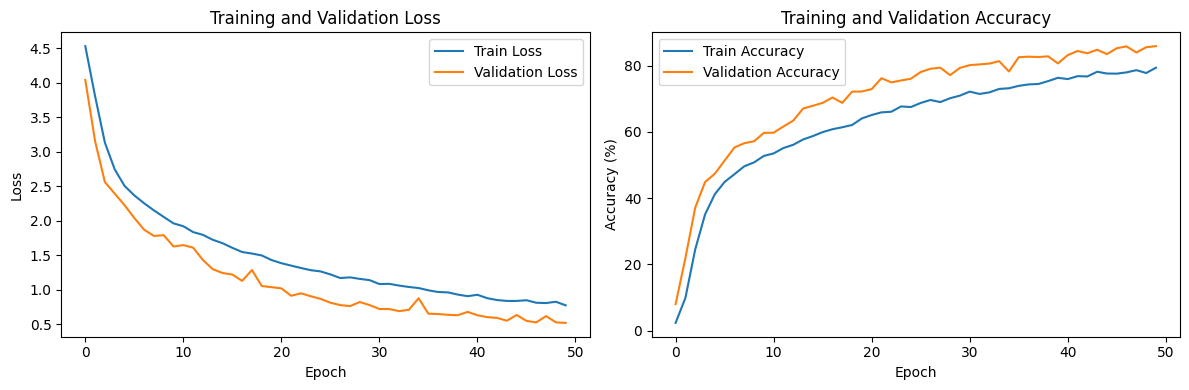

In [118]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion,
                     optimizer, NUM_EPOCHS, device)

# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
test_loss, classification_report = evaluate_model(
    model, test_loader, criterion, device, idx_to_word
)

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print("\nClassification Report:")
print(classification_report)

# Plot training history
plot_training_history(*history)

In [125]:
def test_image(model, image_path, transform, idx_to_word, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_word = idx_to_word[predicted.item()]

        # Get confidence scores
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence = probabilities[0][predicted].item()

    return predicted_word, confidence

# Example usage:
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Test a single image
image_path = "captcha_dataset_2/hard/4_Double.png"  # Replace with your test image path
prediction, confidence = test_image(model, image_path, test_transform, idx_to_word, device)
print(f"Predicted word: {prediction}")
print(f"Confidence: {confidence:.2%}")

Predicted word: double
Confidence: 49.06%
